## Star-Galaxy Classification (Experiment 1) using Vision Transformer (ViT) Model with CLS token derived uisng the Photometric Features. Query is defined using only photometry data (CLS Token) in the attention and defining Cross-Attention.

#### Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
np.random.seed(69)
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
sns.set()
# from tqdm.notebook 
import tqdm
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import time
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from linformer import LinformerCA, Linformer
from vit_pytorch.efficient_new import ViT


#### 1. Load and extract the dataset

In [2]:
X = np.load("/home/srinadb/SG/SGP/Dataset/Experiment1/X_exp1.npy")
dnnx = np.load("/home/srinadb/SG/SGP/Dataset/Experiment1/dnnx_exp1.npy")
objlist = np.load("/home/srinadb/SG/SGP/Dataset/Experiment1/objlist_exp1.npy")
y = np.load("/home/srinadb/SG/SGP/Dataset/Experiment1/y_exp1.npy", allow_pickle=True)

idx_drop = np.where(y=="QSO")[0]
X = np.delete(X,idx_drop,axis=0)
dnnx = np.delete(dnnx,idx_drop,axis=0)
y = np.delete(y,idx_drop,axis=0)
objlist = np.delete(objlist,idx_drop,axis=0)
y, label_strings = pd.factorize(y,sort=True)
# y = to_categorical(y)
print('\n')
print(label_strings)




['GALAXY' 'STAR']


In [3]:
zipX = list(zip(X, dnnx))
zipy = list(zip(y, objlist))

zipX_train, zipX_test, zipy_train, zipy_test = train_test_split(zipX, zipy, test_size = 0.125,random_state=42)
zipX_train, zipX_val, zipy_train, zipy_val = train_test_split(zipX_train, zipy_train, test_size = 0.1428, random_state=42)

X_train, dnnx_train = zip(*zipX_train)
X_val, dnnx_val = zip(*zipX_val)
X_test, dnnx_test = zip(*zipX_test)

y_train, objlist_train = zip(*zipy_train)
y_val, objlist_val = zip(*zipy_val)
y_test, objlist_test = zip(*zipy_test)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

dnnx_train = np.array(dnnx_train)
dnnx_val = np.array(dnnx_val)
dnnx_test = np.array(dnnx_test)

y_train = np.array(y_train)
objlist_train = np.array(objlist_train)
y_val = np.array(y_val)
objlist_val = np.array(objlist_val)
y_test = np.array(y_test)
objlist_test = np.array(objlist_test)

del(zipX,zipX_test,zipX_train,zipX_val, X, zipy, zipy_test, zipy_train, zipy_val, objlist)

X_train = X_train.transpose((0, 3, 1, 2))
X_val = X_val.transpose((0, 3, 1, 2))
X_test = X_test.transpose((0, 3, 1, 2))

print('\n')
print('The shape of the Train data is:', X_train.shape)
print('The shape of the Validation data is:', X_val.shape)
print('The shape of the Test data is:', X_test.shape)




The shape of the Train data is: (120007, 5, 32, 32)
The shape of the Validation data is: (19992, 5, 32, 32)
The shape of the Test data is: (20000, 5, 32, 32)


In [4]:
def get_metrics(y_pred, y_test, labels, to_print=True):
    correct_labels = np.where(y_pred==y_test)[0]
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred,average='macro')
    recall = metrics.recall_score(y_test, y_pred,average='macro')
    f1score = metrics.f1_score(y_test, y_pred,average='macro')
    # rocscore = metrics.roc_auc_score(y_test, y_pred,average='micro',multi_class="ovo")
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)  
    classification_report = metrics.classification_report(y_test, y_pred)

    if to_print:
        print("Identified {} correct labels out of {} labels".format(len(correct_labels), y_test.shape[0]))
        print("Accuracy:",accuracy)
        print("Precision:",precision)
        print("Recall:",recall)
        print("F1 Score:",f1score)
        # print("ROC AUC Score:",rocscore)
        print(f"Labels are: {labels}")
        print("Confusion Matrix:\n", confusion_matrix)
        print("Classification_Report:\n", classification_report)

    return (correct_labels, accuracy, precision, recall, confusion_matrix, classification_report)


##### Create dataset and dataloader for pytorch training

In [5]:
class SGData(Dataset):
    def __init__(self, x1, x2, y, transform=None):
        self.n_samples = x2.shape[0]
        self.x1 = torch.tensor(x1, dtype=torch.float32)
        self.x2 = torch.tensor(x2, dtype=torch.float32)
        self.y = torch.tensor(y)
        self.transform = transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, i):
        inputs_pf, inputs_imgs, targets = self.x1[i], self.x2[i], self.y[i]
        
        if self.transform:
            inputs_pf = inputs_pf
            inputs_imgs = self.transform(inputs_imgs)

        return inputs_pf, inputs_imgs, targets

# Define your data augmentation transformations
image_transform = transforms.Compose([    
    transforms.RandomRotation(180),
    transforms.RandomAffine(degrees = 0, translate = (0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

# Create DataLoader for training and validation data
train_dataset = SGData(dnnx_train, X_train, y_train, transform=image_transform)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=8)
val_dataset = SGData(dnnx_val, X_val, y_val, transform=image_transform)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=4)
test_dataset = SGData(dnnx_test, X_test, y_test, transform=None)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4)


#### 2. Initialize or Define the Model

In [6]:
# Initialize the PyTorch model
n_classes = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
in_channels = X_train.shape[1]

PATCH_SIZE = 4
DEPTH = 12
HIDDEN_DIM = 64
K_DIM = 128
NUM_HEADS = 8

LR = 1e-3
STEP_SIZE = 5
GAMMA = 0.9

LIN_DROPOUT = 0.1

seq_len = int((32/PATCH_SIZE)**2) + 1

## Linformer
lin = LinformerCA(dim=HIDDEN_DIM, seq_len=seq_len, depth=DEPTH, k=K_DIM, heads=NUM_HEADS,
                dim_head=None, one_kv_head=False, share_kv=False, reversible=False, dropout=LIN_DROPOUT)

## Vision Transformer
model = ViT(image_size=32, patch_size=PATCH_SIZE, num_classes=n_classes, dim=HIDDEN_DIM, transformer=lin, pool='cls', channels=in_channels).to(device)


cuda:0


#### 3. Training the model



Epoch [1/300] - Train Loss: 0.3144, Train Accuracy: 0.8538, Validation Loss: 0.1283, Validation Accuracy: 0.9584
Epoch [2/300] - Train Loss: 0.1223, Train Accuracy: 0.9570, Validation Loss: 0.1168, Validation Accuracy: 0.9609
Epoch [3/300] - Train Loss: 0.1071, Train Accuracy: 0.9632, Validation Loss: 0.1052, Validation Accuracy: 0.9671
Epoch [4/300] - Train Loss: 0.1016, Train Accuracy: 0.9654, Validation Loss: 0.0996, Validation Accuracy: 0.9690
Epoch [5/300] - Train Loss: 0.0977, Train Accuracy: 0.9667, Validation Loss: 0.0951, Validation Accuracy: 0.9704
Epoch [6/300] - Train Loss: 0.0926, Train Accuracy: 0.9685, Validation Loss: 0.0917, Validation Accuracy: 0.9713
Epoch [7/300] - Train Loss: 0.0909, Train Accuracy: 0.9690, Validation Loss: 0.0871, Validation Accuracy: 0.9718
Epoch [8/300] - Train Loss: 0.0886, Train Accuracy: 0.9700, Validation Loss: 0.1133, Validation Accuracy: 0.9612
Epoch [9/300] - Train Loss: 0.0860, Train Accuracy: 0.9714, Validation Loss: 0.1181, Validatio

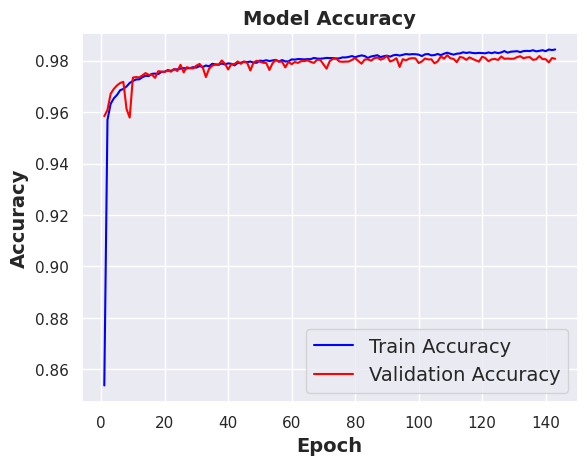

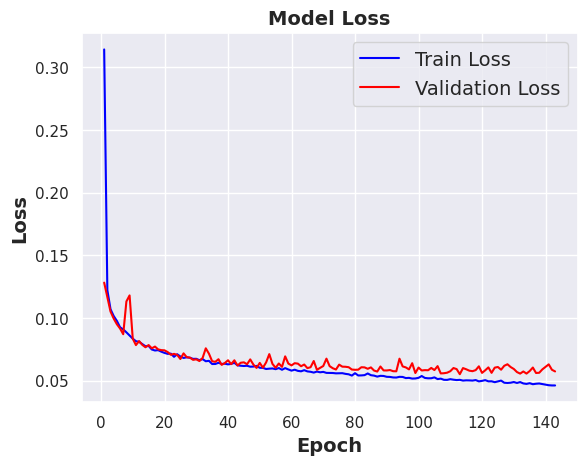

In [7]:
train_loss_arr = []
train_accuracy_arr = []
val_loss_arr = []
val_accuracy_arr = []

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Early stopping parameters
patience = 30
best_val_loss = float('inf')
best_model_state = None  # Initialize a variable to store the best model state
counter = 0

# Training loop
epochs = 300
epoch1 =0
print('\n')
for epoch in range(epochs):
    epoch1+=1
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch_x1, batch_x2, batch_y in train_loader:
        batch_x1 = batch_x1.to(device)
        batch_x2 = batch_x2.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x1, batch_x2)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        total_train += batch_y.size(0)
        correct_train += predicted.eq(batch_y).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = correct_train / total_train
    train_loss_arr.append(train_loss)
    train_accuracy_arr.append(train_accuracy)
    
    model.eval()
    
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch_x1, batch_x2, batch_y in val_loader:
            batch_x1 = batch_x1.to(device)
            batch_x2 = batch_x2.to(device)
            batch_y = batch_y.to(device)
            output = model(batch_x1, batch_x2)
            val_loss += criterion(output, batch_y).item()
            _, predicted = output.max(1)
            total_val += batch_y.size(0)
            correct_val += predicted.eq(batch_y).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct_val / total_val
    val_loss_arr.append(val_loss)
    val_accuracy_arr.append(val_accuracy)
    
    model.train()
        
    #Check for early stopping and save best model state
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_state = model.state_dict()  # Store the current best model state
        torch.save(best_model_state, "Trained_Models/EX1_SG_ViTCLSPFCA_Model.pth")
    else:
        counter += 1

    if counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        if best_model_state is not None:
            model.load_state_dict(best_model_state)  # Restore best model state
        counter = 0  # Reset the counter    
        break

    print(f'Epoch [{epoch+1}/{epochs}] - '
      f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
      f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Create the range of epochs
epoch_range = range(1, epoch1+1)

# Plot training accuracy in blue
plt.figsize=(8, 6)  # Adjust the size as needed
plt.plot(epoch_range, train_accuracy_arr, label='Train Accuracy', color='blue')

# Plot validation accuracy in red
plt.plot(epoch_range, val_accuracy_arr, label='Validation Accuracy', color='red')

# Add labels and title
plt.xlabel('Epoch', fontsize=14, weight='bold')
plt.ylabel('Accuracy', fontsize=14, weight='bold')
plt.title('Model Accuracy', fontsize=14, weight='bold')

# Add a legend
plt.legend(fontsize=14, title_fontproperties={'weight':'bold'})
plt.savefig("Trained_Models/EX1_SG_ViTCLSPFCA_Accuracy.png")
# Show the plot
plt.show()
plt.close()

# Plot training accuracy in blue
plt.figsize=(8, 6)  # Adjust the size as needed
plt.plot(epoch_range, train_loss_arr, label='Train Loss', color='blue')

# Plot validation accuracy in red
plt.plot(epoch_range, val_loss_arr, label='Validation Loss', color='red')

# Add labels and title
plt.xlabel('Epoch', fontsize=14, weight='bold')
plt.ylabel('Loss', fontsize=14, weight='bold')
plt.title('Model Loss', fontsize=14, weight='bold')

# Add a legend
plt.legend(fontsize=14, title_fontproperties={'weight':'bold'})
plt.savefig("Trained_Models/EX1_SG_ViTCLSPFCA_Loss.png")
# Show the plot
plt.show()
plt.close()


#### 4. Testing the Model



Identified 19623 correct labels out of 20000 labels
Accuracy: 0.98115
Precision: 0.9811471825811608
Recall: 0.9811591105423492
F1 Score: 0.981149788453501
Labels are: ['GALAXY' 'STAR']
Confusion Matrix:
 [[9778  170]
 [ 207 9845]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      9948
           1       0.98      0.98      0.98     10052

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000

(array([    0,     1,     2, ..., 19997, 19998, 19999]), 0.98115, 0.9811471825811608, 0.9811591105423492, array([[9778,  170],
       [ 207, 9845]]), '              precision    recall  f1-score   support\n\n           0       0.98      0.98      0.98      9948\n           1       0.98      0.98      0.98     10052\n\n    accuracy                           0.98     20000\n   macro avg       0.98      0.98      0.

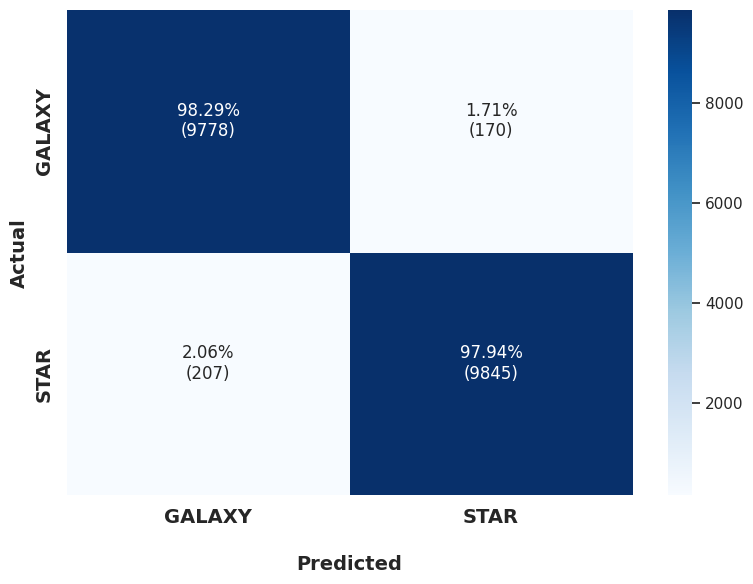

In [ ]:
torch.cuda.empty_cache()

# Set the model to evaluation mode
model.eval()
y_test_pred = torch.empty(0).to(device)
print('\n')
# Generate predictions
with torch.no_grad():
    for pf, images, labels in test_loader:
        pf = pf.to(device)
        images = images.to(device)
        labels = labels.to(device)
        pred = model(pf, images)

        y_test_pred = torch.cat((y_test_pred, pred), dim=0)

y_test_pred = y_test_pred.cpu().numpy()
y_test_pred = y_test_pred.argmax(axis=1)
print(get_metrics(y_test_pred, y_test, label_strings))

# https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/#google_vignette
# fig = plt.figure()
cf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
cf_matrix_percentage = metrics.confusion_matrix(y_test, y_test_pred, normalize='true')
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_percentage.flatten()]
labels = [f"{v1}\n({v2})\n" for v1, v2 in
          zip(group_percentages,group_counts)]
labels = np.asarray(labels).reshape(2,2)
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the size as needed

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_xlabel('\nPredicted', fontsize=14, weight='bold')
ax.set_ylabel('Actual', fontsize=14, weight='bold');
ax.xaxis.set_ticklabels(['GALAXY', 'STAR'], fontsize=14, weight='bold')
ax.yaxis.set_ticklabels(['GALAXY', 'STAR'], fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig("Trained_Models/EX1_SG_ViTCLSPFCA_CM.png")
plt.show()
plt.close()